In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import attila_utils
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def read_group(group='all_control', cohort='MSBB'):
    bname = '../../resources/tunahan/Busra-2023-02-05/active_reactions/'
    suffix = '.xlsx'
    fpath = bname + cohort + '/' + group + suffix
    df = pd.read_excel(fpath, 'Sheet1', index_col='rxn_ID')
    return(df)

groupdict = {
    'control': 'all_control',
    'AD': 'nosubtyping_AD',
    'AD A': 'SubtypeA_AD',
    'AD B1': 'SubtypeB1_AD',
    'AD B2': 'SubtypeB2_AD',
    'AD C1': 'SubtypeC1_AD',
    'AD C2': 'SubtypeC2_AD',
}

# active reactions in the MSSM cohort
arM = {k: read_group(v, cohort='MSBB') for k, v in groupdict.items()}

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


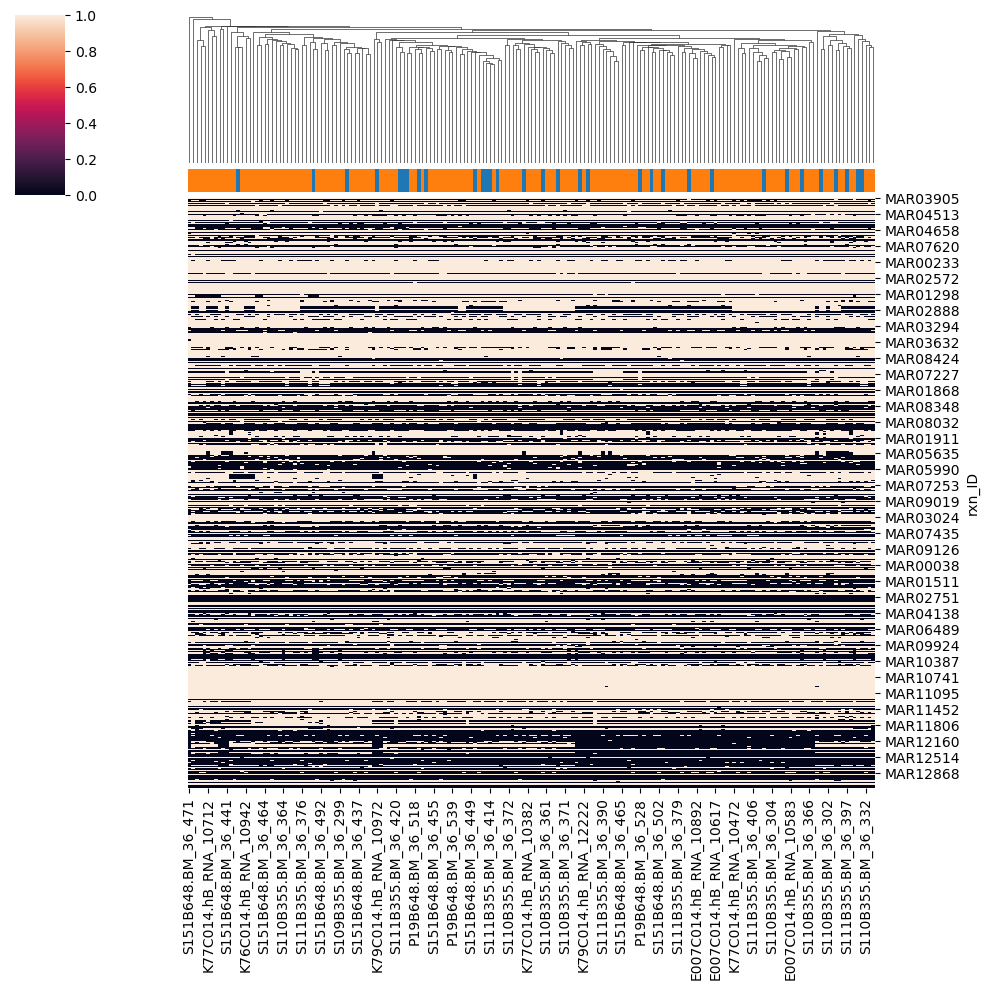

In [3]:
def my_clustermap(sel_groups=['control', 'AD'], ar=arM, col_cluster=True):
    coldict = {g: 'C' + str(i) for i, g in enumerate(sel_groups)}
    col_colors = list(itertools.chain(*[[v] * arM[k].shape[1] for k, v in coldict.items()]))
    g = sns.clustermap(pd.concat([arM[g] for g in sel_groups], axis=1), row_cluster=False, col_cluster=col_cluster, col_colors=col_colors)
    return(g)

g = my_clustermap(sel_groups=['control', 'AD'], ar=arM)

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


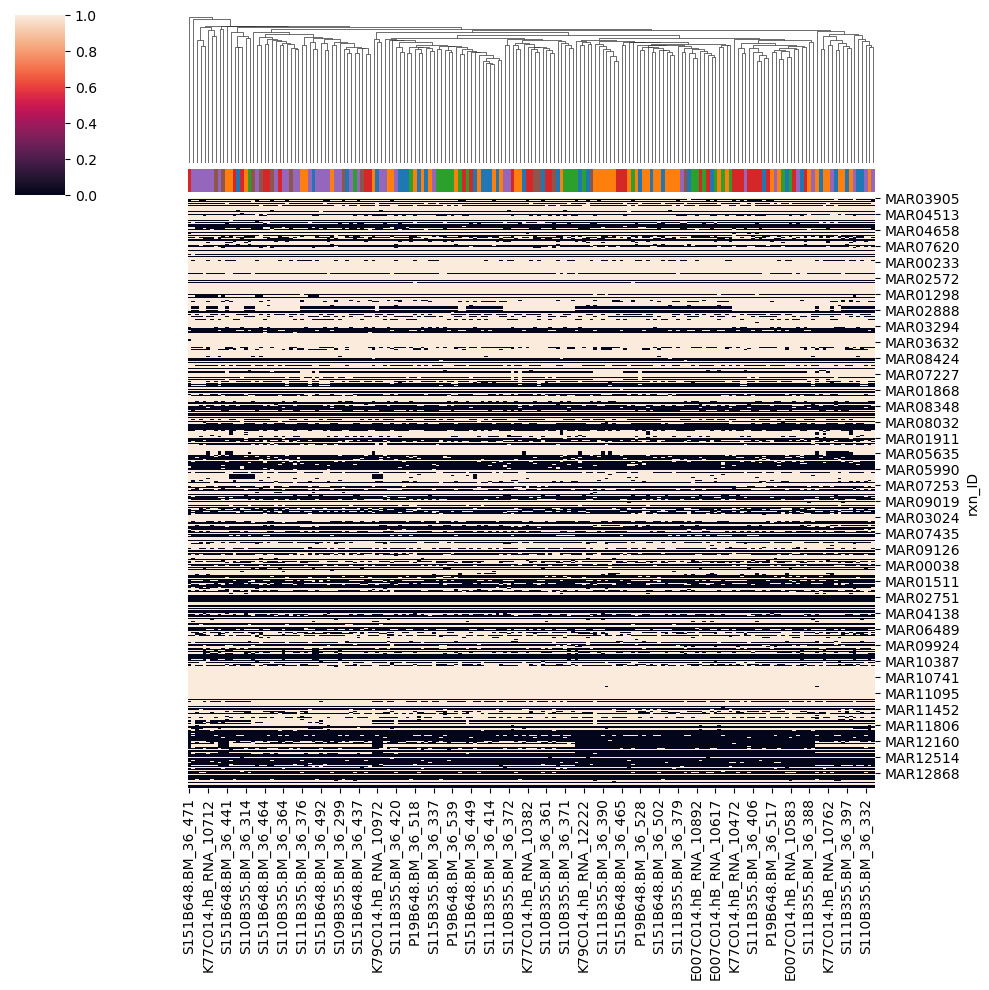

In [4]:
g = my_clustermap(sel_groups=['control', 'AD A', 'AD B1', 'AD B2', 'AD C1', 'AD C2'], ar=arM)

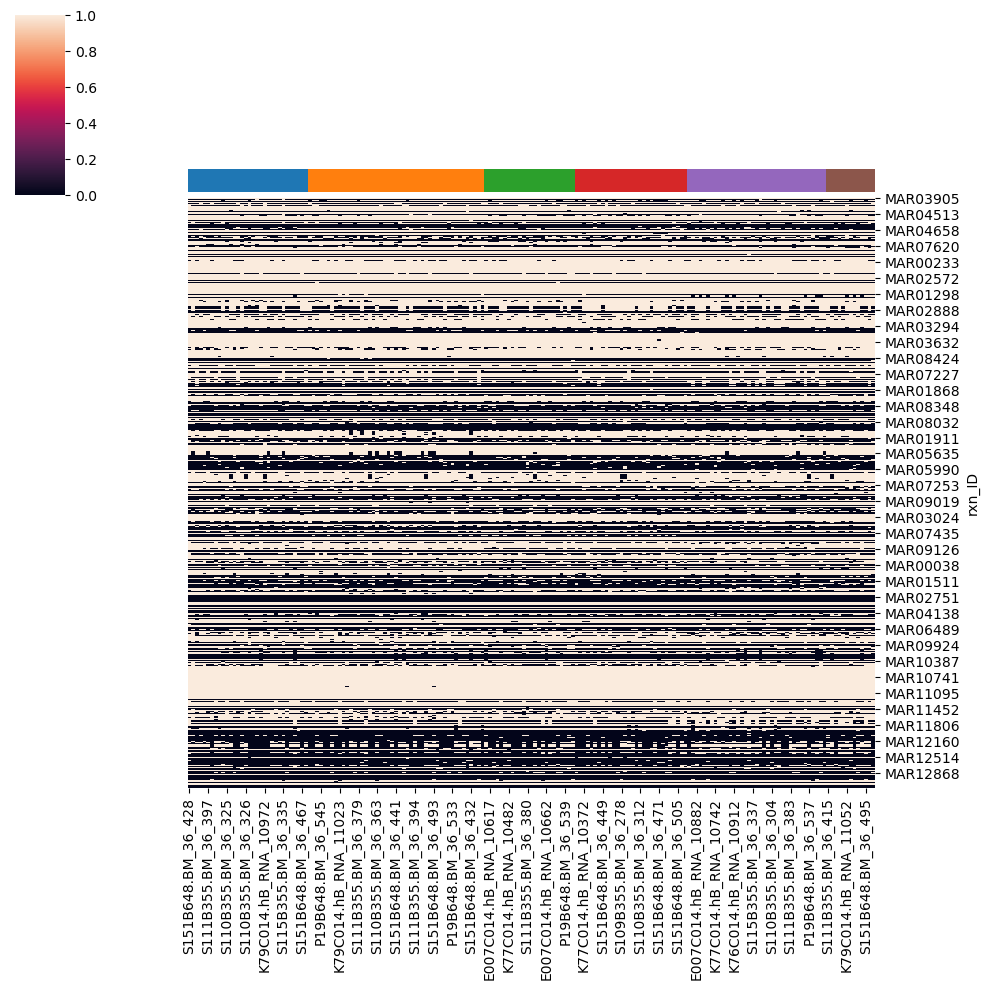

In [5]:
g = my_clustermap(sel_groups=['control', 'AD A', 'AD B1', 'AD B2', 'AD C1', 'AD C2'], ar=arM, col_cluster=False)

In [6]:
%connect_info

{
  "shell_port": 64771,
  "iopub_port": 64772,
  "stdin_port": 64773,
  "control_port": 64775,
  "hb_port": 64774,
  "ip": "127.0.0.1",
  "key": "2d50ea96-b51d4befe6004d2229353051",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-455c436c-6bee-45fc-966b-855d19aaa68f.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
